# Dual Ultimatum Tournament Prototype

In [68]:
import glob, os, sys
import numpy as np
import pandas as pd
import plotnine as pn
from random import sample
DATA_DIR = '/Users/kurtsmith/research/spinningup/data'
pd.options.display.max_columns=None

In [69]:
from spinup.my_algos.ultimatum_agents import *
from spinup.environments.dual_ultimatum_env import *

In [1]:
from multiagent-rl.algos.ultimatum_agents import *

SyntaxError: invalid syntax (<ipython-input-1-c57f34a7b421>, line 1)

In [2]:
echo $PATH

SyntaxError: invalid syntax (<ipython-input-2-d5d54b710d29>, line 1)

In [70]:
def assign_match_pairs(num_agents):
    """Create random pairings for an even number of agents"""
    assert num_agents % 2 == 0
    shuffled = sample(range(num_agents), k=num_agents)
    match_pairs = [shuffled[i:i+2] for i in range(0, num_agents, 2)]
    return match_pairs

In [71]:
# Initialize agents:
agent_0 =ConstantBot(offer=0.5, threshold=1.0)
agent_1 =ConstantBot(offer=0.6, threshold=0.)
agent_2 =ConstantBot(offer=0.8, threshold=0.)
agent_3 =ConstantBot(offer=0.2, threshold=0.)
agent_list = [agent_0, agent_1, agent_2, agent_3]

In [72]:
# Initialize agents:
agent_0 =ConstantBot(offer=0.2, threshold=0.8)
agent_1 = StaticDistribBot(
    mean_offer=0.5, std_offer=0.1, mean_threshold=0.5, std_threshold=0.1
)
agent_2 = StaticDistribBot(
    mean_offer=0.5, std_offer=1., mean_threshold=0.5, std_threshold=1.
)
agent_3 = StaticDistribBot(
    mean_offer=0.5, std_offer=2., mean_threshold=0.5, std_threshold=2.
)
agent_list = [agent_0, agent_1, agent_2, agent_3]

Main loop over rounds of tournament


For each agent, input should be:

- all actions from last turn of own match
    - with own actions first 
- current overall scores for all agents (can use same order for all agents)
- ?score of current opponent
- number of rounds left in tournament
- ?number of turns left in current round - omit for now, treat as random length game

In [76]:
num_agents = len(agent_list)

In [78]:
obs_dim = 4 + num_agents + 1 + 1

all_obs = np.zeros((num_agents, obs_dim))
all_obs_next = np.zeros((num_agents, obs_dim))
# Observations are:
# 4 (match obs)
# num_agents (scores)
# 1 opponent score
# 1 rounds left
# ? should we add more for rankings/thresholds?
# opponent id, OHE??? useful when we add bots, or other differences?

In [80]:
env_obs_list

[array([0.5, 0.5, 0.5, 0.5]), array([0.5, 0.5, 0.5, 0.5])]

In [81]:
np.random.randn(4)

array([-1.91573671, -0.63396282,  0.02982265, -0.59531569])

In [79]:
num_rounds = 10
round_length = 2
score_list = np.zeros(len(agent_list))
for i_round in reversed(range(num_rounds)):
    
    # Initialize match info and environments
    match_pairs = assign_match_pairs(4)
    match_env_list = [DualUltimatum(), DualUltimatum()]
    agent_opponent_dict = dict()
    agent_match_dict = dict()
    for i, m in enumerate(match_pairs):
        agent_opponent_dict[m[0]] = m[1]
        agent_opponent_dict[m[1]] = m[0]
        agent_match_dict[m[0]] = i
        agent_match_dict[m[1]] = i
    
    # Generate initial obs for each match
    env_obs_list = [env.reset() for env in match_env_list]
    ag_obs_list = [env_obs_list[agent_match_dict[ag]] for ag in range(len(agent_list))]
    ag_obs_next_list = ag_obs_list

    # Loop through single round
    for _ in range(round_length):
        
        # Get each agent's actions
        agent_acts = [ag.act(o) for ag, o in zip(agent_list, ag_obs_list)]

        # Rearrange actions to as input for each match environment
        match_acts = [
            np.array([agent_acts[i] for i in match])
            for match in match_pairs]

        # Pass actions to each match env, get next obs/reward
        match_outputs = [match_env.step(acts) for acts, match_env in zip(match_acts, match_env_list)]

        # Update scores based on env steps
        for pair, output in zip(match_pairs, match_outputs):
            o, r, d, _ = output
            score_list[pair] += r
            ag_obs_next_list[pair[0]] = o
            ag_obs_next_list[pair[1]] = np.roll(o, 2)
#             for ag, r_ag in zip(agent_pair, r):
#                 ag_obs_next_list[ag] = o
#                 score_list[ag] += r_ag

        ag_obs_list = ag_obs_next_list
print(f'match_pairs {match_pairs}')
print(f'scores {score_list}') 

match_pairs [[1, 3], [2, 0]]
scores [6.93168245 3.30347399 5.13337888 2.63146467]


/Users/kurtsmith/miniconda3/envs/spinningup/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32


In [61]:
print(score_list)
print(agent_pair)

[1.66841718 3.46834713 1.97518487 2.88805082]
[3, 2]


In [64]:
score_list[agent_pair] += r

In [66]:
print(o)
print(np.roll(o,2))

[0.99510422 0.8171934  0.11001134 0.04352573]
[0.11001134 0.04352573 0.99510422 0.8171934 ]


Data shapes:

- na = # of agents
- nm = # of match_pairs (= na/2)
- nobs = length of obs vector
- 2 = action space for single agent

agent_acts - (na, 2)
match_acts - (nm, (2,2))
match_env_list - (nm) (env for each match)
match_output - (nm)
ag_obs_list - (na, nobs)
ag_obs_next_list - same

In [36]:
# to do: check if own score is first
# Add global scores to obs
ff = [np.concatenate((o, score_list)) for o in ag_obs_next_list]
# Add current round to obs
ff = [np.append(x, i_round) for x in ff]
# Add opponent's score
for i in range(len(ff)):
    ff[i] = np.append(ff[i], score_list[agent_opponent_dict[i]])

In [54]:
match_output

[(array([0.89298033, 0.56163017, 0.5513665 , 0.46566673]),
  array([0, 0]),
  False,
  {}),
 (array([0.2       , 0.8       , 0.87506763, 0.96054561]),
  array([0, 0]),
  False,
  {})]

In [46]:
ff

[array([0.2       , 0.8       , 0.87506763, 0.96054561, 1.79109891,
        6.54152624, 0.94673824, 2.72063661, 0.        ]),
 array([0.89298033, 0.56163017, 0.5513665 , 0.46566673, 1.79109891,
        6.54152624, 0.94673824, 2.72063661, 0.        ]),
 array([0.89298033, 0.56163017, 0.5513665 , 0.46566673, 1.79109891,
        6.54152624, 0.94673824, 2.72063661, 0.        ]),
 array([0.2       , 0.8       , 0.87506763, 0.96054561, 1.79109891,
        6.54152624, 0.94673824, 2.72063661, 0.        ])]

In [53]:
ff

[array([0.2       , 0.8       , 0.87506763, 0.96054561, 1.79109891,
        6.54152624, 0.94673824, 2.72063661, 0.        , 2.72063661,
        2.72063661]),
 array([0.89298033, 0.56163017, 0.5513665 , 0.46566673, 1.79109891,
        6.54152624, 0.94673824, 2.72063661, 0.        , 0.94673824,
        0.94673824]),
 array([0.89298033, 0.56163017, 0.5513665 , 0.46566673, 1.79109891,
        6.54152624, 0.94673824, 2.72063661, 0.        , 6.54152624,
        6.54152624]),
 array([0.2       , 0.8       , 0.87506763, 0.96054561, 1.79109891,
        6.54152624, 0.94673824, 2.72063661, 0.        , 1.79109891,
        1.79109891])]

In [37]:
ff

[array([0.2       , 0.8       , 0.87506763, 0.96054561, 1.79109891,
        6.54152624, 0.94673824, 2.72063661, 0.        ]),
 array([0.89298033, 0.56163017, 0.5513665 , 0.46566673, 1.79109891,
        6.54152624, 0.94673824, 2.72063661, 0.        ]),
 array([0.89298033, 0.56163017, 0.5513665 , 0.46566673, 1.79109891,
        6.54152624, 0.94673824, 2.72063661, 0.        ]),
 array([0.2       , 0.8       , 0.87506763, 0.96054561, 1.79109891,
        6.54152624, 0.94673824, 2.72063661, 0.        ])]

In [35]:
np.append(ff[0], 4)

array([0.2       , 0.8       , 0.67611784, 0.98342819, 5.11873359,
       3.8930339 , 4.88775456, 2.10047795, 4.        ])

In [17]:
ag_obs_next_list[0]

array([0.2       , 0.8       , 0.67611784, 0.98342819])

In [13]:
score_list

array([5.11873359, 3.8930339 , 4.88775456, 2.10047795])

In [185]:
num_rounds = 10
round_length = 2
score_list = np.zeros(len(agent_list))
for round in range(num_rounds):
    match_pairs = assign_match_pairs(4)
    env_list = [DualUltimatum(), DualUltimatum()]
    agent_opponent_dict = dict()
    agent_match_dict = dict()
    for i, m in enumerate(match_pairs):
        agent_opponent_dict[m[0]] = m[1]
        agent_opponent_dict[m[1]] = m[0]
        agent_match_dict[m[0]] = i
        agent_match_dict[m[1]] = i
    
    # Generate initial obs for each match
    env_obs_list = [env.reset() for env in env_list]
    ag_obs_list = [env_obs_list[agent_match_dict[ag]] for ag in range(len(agent_list))]
    ag_obs_next_list = ag_obs_list

    for _ in range(round_length):
        # Get each agent's actions
        agent_acts = [ag.act(o) for ag, o in zip(agent_list, ag_obs_list)]

        # Rearrange actions to each match
        match_acts = [
            np.array([agent_acts[i] for i in match])
            for match in match_pairs]

        # Pass actions to each match env
        match_output = [env.step(acts) for acts, env in zip(match_acts, env_list)]

        # Update scores based on env steps
        for agents, output, obs_next in zip(match_pairs, match_output, obs_next_list):
            o, r, d, _ = output
            for ag, r_ag in zip(agents, r):
                ag_obs_next_list[ag] = o
                score_list[ag] += r_ag

        ag_obs_list = ag_obs_next_list
print(f'match_pairs {match_pairs}')
print(f'scores {score_list}') 

matches [[0, 3], [2, 1]]
scores [0.         4.92670313 2.16138606 2.91191081]


In [186]:
# create obs for each agent
print(match_output[0][0])
print(np.roll(match_output[0][0], 2))

[2.00000000e-01 8.00000000e-01 7.18261354e-04 6.68076748e-01]
[7.18261354e-04 6.68076748e-01 2.00000000e-01 8.00000000e-01]


In [187]:
for m, e in zip(match_pairs, match_output):
    print(m)
    print(e[0])
    print('===')
    ag_obs_next_list[m[0]] = e[0]
    ag_obs_next_list[m[1]] = np.roll(e[0],2)

[0, 3]
[2.00000000e-01 8.00000000e-01 7.18261354e-04 6.68076748e-01]
===
[2, 1]
[0.55248612 0.62624217 0.51905748 0.40240445]
===


In [188]:
ag_obs_next_list

[array([2.00000000e-01, 8.00000000e-01, 7.18261354e-04, 6.68076748e-01]),
 array([0.51905748, 0.40240445, 0.55248612, 0.62624217]),
 array([0.55248612, 0.62624217, 0.51905748, 0.40240445]),
 array([7.18261354e-04, 6.68076748e-01, 2.00000000e-01, 8.00000000e-01])]

In [88]:
# Initialize 1-on-1 match_pairs
env_list = [DualUltimatum(), DualUltimatum()]
match_pairs = [(0,1), (2,3)]
agent_opponent_dict = dict()
agent_match_dict = dict()

/Users/kurtsmith/miniconda3/envs/spinningup/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32


In [89]:
for i, m in enumerate(match_pairs):
    agent_opponent_dict[m[0]] = m[1]
    agent_opponent_dict[m[1]] = m[0]
    agent_match_dict[m[0]] = i
    agent_match_dict[m[1]] = i

In [92]:
# Generate initial obs for each match
env_obs_list = [env.reset() for env in env_list]

In [93]:
env_obs_list

[array([0.5, 0.5, 0.5, 0.5]), array([0.5, 0.5, 0.5, 0.5])]

In [103]:
ag_obs_list = [env_obs_list[agent_match_dict[ag]] for ag in range(len(agent_list))]
ag_obs_next_list = ag_obs_list

In [107]:
def one_turn():
    # Get each agent's actions
    agent_acts = [ag.act(o) for ag, o in zip(agent_list, ag_obs_list)]

    # Rearrange actions to each match
    match_acts = [
        np.array([agent_acts[i] for i in match])
        for match in match_pairs]

    # Pass actions to each match env
    match_output = [env.step(acts) for acts, env in zip(match_acts, env_list)]

    # Update scores based on env steps
    for agents, output, obs_next in zip(match_pairs, match_output, obs_next_list):
        o, r, d, _ = output
        print('----')
        print(o)
        print('****')
        for ag, r_ag in zip(agents, r):
            ag_obs_next_list[ag] = o
            score_list[ag] += r_ag

    ag_obs_list = ag_obs_next_list
    
    

In [112]:

num_turns = 10
print(score_list)
for _ in range(num_turns):
    # Get each agent's actions
    agent_acts = [ag.act(o) for ag, o in zip(agent_list, ag_obs_list)]

    # Rearrange actions to each match
    match_acts = [
        np.array([agent_acts[i] for i in match])
        for match in match_pairs]

    # Pass actions to each match env
    match_output = [env.step(acts) for acts, env in zip(match_acts, env_list)]

    # Update scores based on env steps
    for agents, output, obs_next in zip(match_pairs, match_output, obs_next_list):
        o, r, d, _ = output
#         print('----')
#         print(o)
#         print('****')
        for ag, r_ag in zip(agents, r):
            ag_obs_next_list[ag] = o
            score_list[ag] += r_ag

    ag_obs_list = ag_obs_next_list
    print(score_list)

[0. 0. 0. 0.]
[1.1 0.9 0.  0. ]
[2.2 1.8 0.  0. ]
[3.3 2.7 0.  0. ]
[4.4 3.6 0.  0. ]
[5.5 4.5 0.  0. ]
[6.6 5.4 0.  0. ]
[7.7 6.3 0.  0. ]
[8.8 7.2 0.  0. ]
[9.9 8.1 0.  0. ]
[11.  9.  0.  0.]


In [56]:
print(match_pairs)
print(scores)

[(0, 1), (2, 3)]
[2.2 1.8 0.  0. ]


In [50]:
scores[agents[0]] += r[0]

array([0, 0])

In [48]:
print(output)

(array([0.8, 0.7, 0.2, 0.1]), array([0, 0]), False, {})


In [35]:
for i, env in enumerate(env_list):
    print(i)
    print(env.step(match_acts[i]))


0
(array([0.5, 0.5, 0.6, 0.5]), array([1.1, 0.9]), False, {})
1
(array([0.8, 0.7, 0.2, 0.1]), array([0, 0]), False, {})


In [6]:
obs, env.step(act)

(array([0.5, 0.5, 0.7, 0.1]), array([1.2, 0.8]), False, {})

In [1]:
import pandas as pd
import plotnine as pn

In [90]:
DATA_DIR = '/Users/kurtsmith/research/spinningup/data/tournament/dual_ultimatum'

In [317]:
# Simple l1 dist score, different reward structures
# per turn
# run_num = '1598647624'
# delayed cumul
# run_num = '1598649108'

# 1 round, 2 turns
# run_num = '1598649273'
# 1 round, 2 turns, std=0.5 for exploration
# run_num = '1598649839'

# 2 rounds, 1 turn, std=0.5
# run_num = '1598650120'

# 1 round, 10 turns, std=0.5 for exploration
# run_num = '1598650390'

# 1 round, 10 turns, std=0.5 for exploration, use score as obs
# run_num = '1598651674'
# With all agents' scores as features
# run_num = '1598661743'

# ranking reward with fixed target (0.3)
# run_num = '1598662364'

# per_turn reward with no obs
# run_num = '1598664313'

# per_turn reward with no obs, extra 128 layer
# run_num = '1598664619'
# run_num = '1598664999' #std = 0.2
# run_num = '1598665192'#std = 0.1

# distrib bot
#run_num = '1598665807'
run_num = '1598666318'
q = pd.read_csv(f"{DATA_DIR}/{run_num}/q_49.csv")

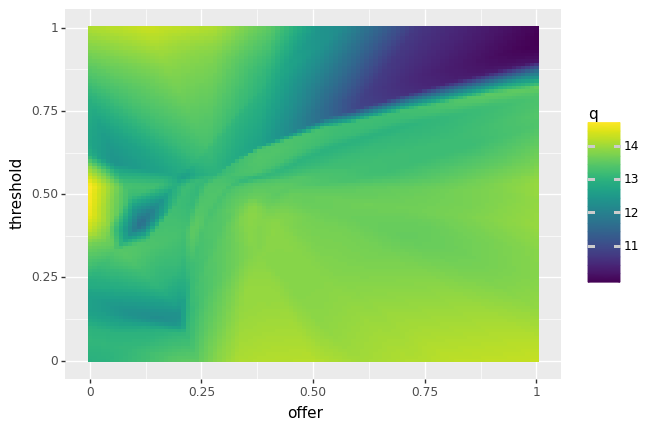

<ggplot: (-9223363252219354813)>

In [319]:
pn.ggplot(q, pn.aes(x='offer', y='threshold', fill='q')) + pn.geom_tile()

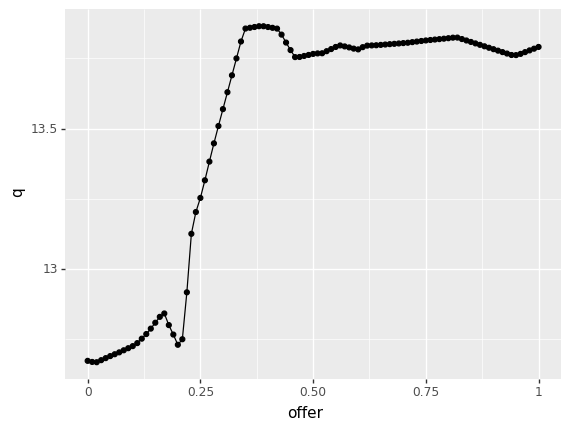

<ggplot: (8784635908493)>

In [320]:
pn.ggplot(q[q.threshold==0.2], pn.aes(x='offer', y='q')) + pn.geom_line() + pn.geom_point()

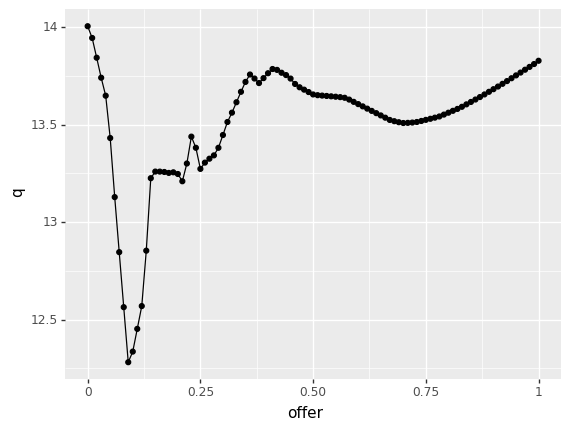

<ggplot: (-9223363252438680453)>

In [322]:
pn.ggplot(q[q.threshold==0.38], pn.aes(x='offer', y='q')) + pn.geom_line() + pn.geom_point()

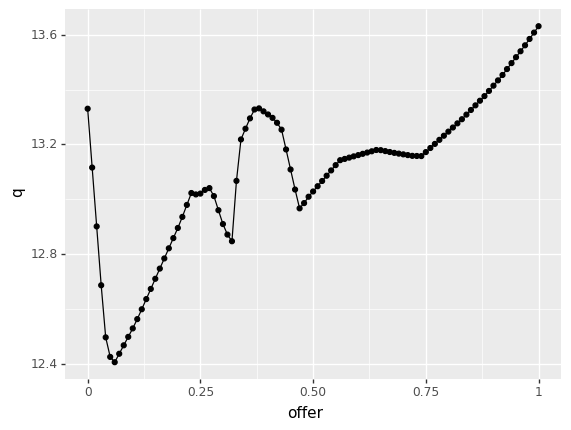

<ggplot: (-9223363252319566378)>

In [323]:
pn.ggplot(q[q.threshold==0.6], pn.aes(x='offer', y='q')) + pn.geom_line() + pn.geom_point()